# Machine Learning Security Final Project - Part 2

This notebook implements defense mechanisms against machine learning attacks.

## Phase 1: Poisoning Defense Implementation

### 1. Data Sanitization Techniques
- Implement anomaly detection (Isolation Forest/MAD)
- Apply spectral signature analysis for poisoned sample removal

=== DATA SANITIZATION TECHNIQUES ===
✓ Loaded clean training data: 34999 samples
✓ Created poisoned dataset with 3499 poisoned samples

1.1 Isolation Forest Anomaly Detection
  - Training Isolation Forest with 100 trees
✓ Loaded clean training data: 34999 samples
✓ Created poisoned dataset with 3499 poisoned samples

1.1 Isolation Forest Anomaly Detection
  - Training Isolation Forest with 100 trees
  - Detected 3500 outliers
  - True poisoned samples: 3499
  - Precision: 0.097
  - Recall: 0.097
  - F1-Score: 0.097
  - Detected 3500 outliers
  - True poisoned samples: 3499
  - Precision: 0.097
  - Recall: 0.097
  - F1-Score: 0.097
  - Anomaly score range: [-0.116, 0.140]

1.2 Visualization
  - Anomaly score range: [-0.116, 0.140]

1.2 Visualization
  - Applied PCA for visualization (explained variance: 0.098)
  - Applied PCA for visualization (explained variance: 0.098)


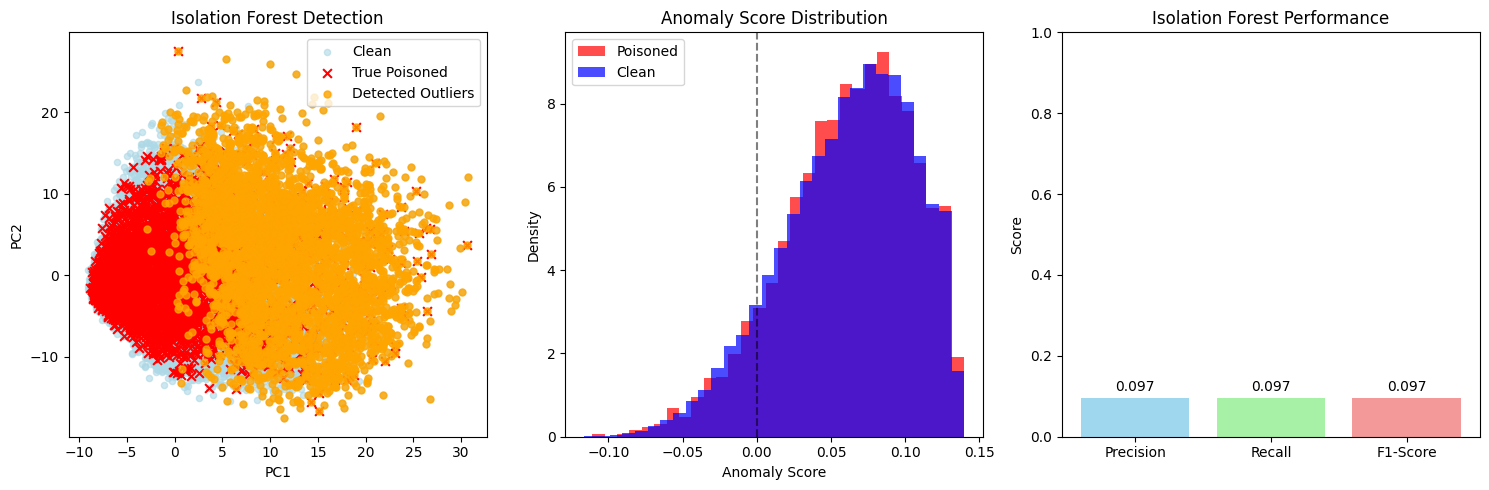


1.3 Data Cleaning Results
Original training set size: 34999
Samples to remove: 3500
Cleaned training set size: 31499
Poison samples remaining: 3161
Poison removal rate: 9.7%
✓ Data sanitization with Isolation Forest completed


In [1]:
# =============================================================================
# 1. DATA SANITIZATION TECHNIQUES
# =============================================================================
# This section will implement Isolation Forest (random forest-based) anomaly detection
# to identify and remove poisoned samples from the training data.
# Method: Isolation Forest

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load data from Part 1
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Load the preprocessed data and poisoned indices from Part 1
from scripts.preprocessing import load_preprocessed_data
from scripts.data_poisoning import create_label_flip_poison

print("=== DATA SANITIZATION TECHNIQUES ===")

# Load clean training data
data = load_preprocessed_data()
if data is not None:
    X_train, y_train, X_val, y_val, X_test, y_test = data
    print(f"✓ Loaded clean training data: {X_train.shape[0]} samples")
else:
    print("⚠ Could not load preprocessed data. Please run Part 1 first.")

# Create poisoned dataset for demonstration
poison_fraction = 0.1
target_label = 0
X_train_poisoned, y_train_poisoned, poisoned_indices = create_label_flip_poison(
    X_train, y_train, poison_fraction=poison_fraction, 
    target_label=target_label, seed=42
)

print(f"✓ Created poisoned dataset with {len(poisoned_indices)} poisoned samples")

# =============================================================================
# 1.1 ISOLATION FOREST ANOMALY DETECTION
# =============================================================================
print("\n1.1 Isolation Forest Anomaly Detection")

# Initialize Isolation Forest (random forest-based anomaly detector)
iso_forest = IsolationForest(
    contamination=poison_fraction,  # Expected fraction of outliers
    random_state=42,
    n_estimators=100,               # Number of trees in the forest
    max_samples='auto',             # Number of samples to draw for training each tree
    max_features=1.0,               # Number of features to draw for training each tree
    bootstrap=False,                # Sample without replacement
    n_jobs=-1                       # Use all processors
)

print(f"  - Training Isolation Forest with {iso_forest.n_estimators} trees")

# Fit and predict outliers
outlier_predictions = iso_forest.fit_predict(X_train_poisoned)
detected_outliers = np.where(outlier_predictions == -1)[0]

print(f"  - Detected {len(detected_outliers)} outliers")
print(f"  - True poisoned samples: {len(poisoned_indices)}")

# Calculate detection metrics
true_positives = len(set(detected_outliers) & set(poisoned_indices))
false_positives = len(detected_outliers) - true_positives
false_negatives = len(poisoned_indices) - true_positives

precision = true_positives / len(detected_outliers) if len(detected_outliers) > 0 else 0
recall = true_positives / len(poisoned_indices) if len(poisoned_indices) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"  - Precision: {precision:.3f}")
print(f"  - Recall: {recall:.3f}")
print(f"  - F1-Score: {f1_score:.3f}")

# Get anomaly scores for visualization
anomaly_scores = iso_forest.decision_function(X_train_poisoned)
print(f"  - Anomaly score range: [{anomaly_scores.min():.3f}, {anomaly_scores.max():.3f}]")

# =============================================================================
# 1.2 VISUALIZATION
# =============================================================================
print("\n1.2 Visualization")

# Apply PCA for visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_poisoned)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"  - Applied PCA for visualization (explained variance: {pca.explained_variance_ratio_.sum():.3f})")

# Create visualization
plt.figure(figsize=(15, 5))

# Plot 1: Isolation Forest detection results
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightblue', alpha=0.6, s=20, label='Clean')
plt.scatter(X_pca[poisoned_indices, 0], X_pca[poisoned_indices, 1], c='red', s=40, label='True Poisoned', marker='x')
plt.scatter(X_pca[detected_outliers, 0], X_pca[detected_outliers, 1], c='orange', s=25, alpha=0.8, label='Detected Outliers')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Isolation Forest Detection')
plt.legend()

# Plot 2: Anomaly scores distribution
plt.subplot(1, 3, 2)
plt.hist(anomaly_scores[poisoned_indices], bins=30, alpha=0.7, label='Poisoned', density=True, color='red')
plt.hist(anomaly_scores[~np.isin(range(len(anomaly_scores)), poisoned_indices)], bins=30, alpha=0.7, label='Clean', density=True, color='blue')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Anomaly Score Distribution')
plt.legend()
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Decision Threshold')

# Plot 3: Detection performance metrics
plt.subplot(1, 3, 3)
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1_score]
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.ylabel('Score')
plt.title('Isolation Forest Performance')
plt.ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# =============================================================================
# 1.3 DATA CLEANING
# =============================================================================
print("\n1.3 Data Cleaning Results")

print(f"Original training set size: {len(X_train_poisoned)}")
print(f"Samples to remove: {len(detected_outliers)}")

# Create cleaned dataset by removing detected outliers
clean_mask = ~np.isin(range(len(X_train_poisoned)), detected_outliers)
X_train_cleaned = X_train_poisoned[clean_mask]
y_train_cleaned = y_train_poisoned[clean_mask]

print(f"Cleaned training set size: {len(X_train_cleaned)}")

# Check how many poison samples remain
remaining_poison = len(set(poisoned_indices) - set(detected_outliers))
print(f"Poison samples remaining: {remaining_poison}")
print(f"Poison removal rate: {((len(poisoned_indices) - remaining_poison) / len(poisoned_indices) * 100):.1f}%")

print("✓ Data sanitization with Isolation Forest completed")

# Store cleaned data for use in subsequent phases
globals()['X_train_cleaned'] = X_train_cleaned
globals()['y_train_cleaned'] = y_train_cleaned
globals()['detection_metrics'] = {
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'detected_outliers': len(detected_outliers),
    'true_positives': true_positives,
    'false_positives': false_positives,
    'false_negatives': false_negatives
}

### 2. Robust Training Methods
- Integrate regularization (Dropout/Weight Clipping)
- Explore differentially private training

=== ROBUST TRAINING METHODS ===
✓ Using cleaned data from data sanitization step
Training data shape: (31499, 784)
Number of training samples: 31499

2.1 Building Baseline Model (No Dropout)


c:\MachineLearningSecurityFinalProjectDirectory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ Baseline model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,762 (948.29 KB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training baseline model...
Epoch 1/50
Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6966 - loss: 0.9611 - val_accuracy: 0.9206 - val_loss: 0.3279
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6966 - loss: 0.9611 - val_accuracy: 0.9206 - val_loss: 0.3279
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8303 - loss: 0.5948 - val_accuracy: 0.9475 - val_loss: 0.2434
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8303 - loss: 0.5948 - val_accuracy: 0.9475 - val_loss: 0.2434
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8533 - loss: 0.5170 - val_accuracy: 0.9559 - val_loss: 0.2312
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8533 - loss: 0.5170 - val_accuracy: 0.9559 - val_loss: 0.2312
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8635 - loss: 0.4786 - val_accuracy: 0.9619 - val_loss: 0.2166
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy:

TypeError: 'History' object is not subscriptable

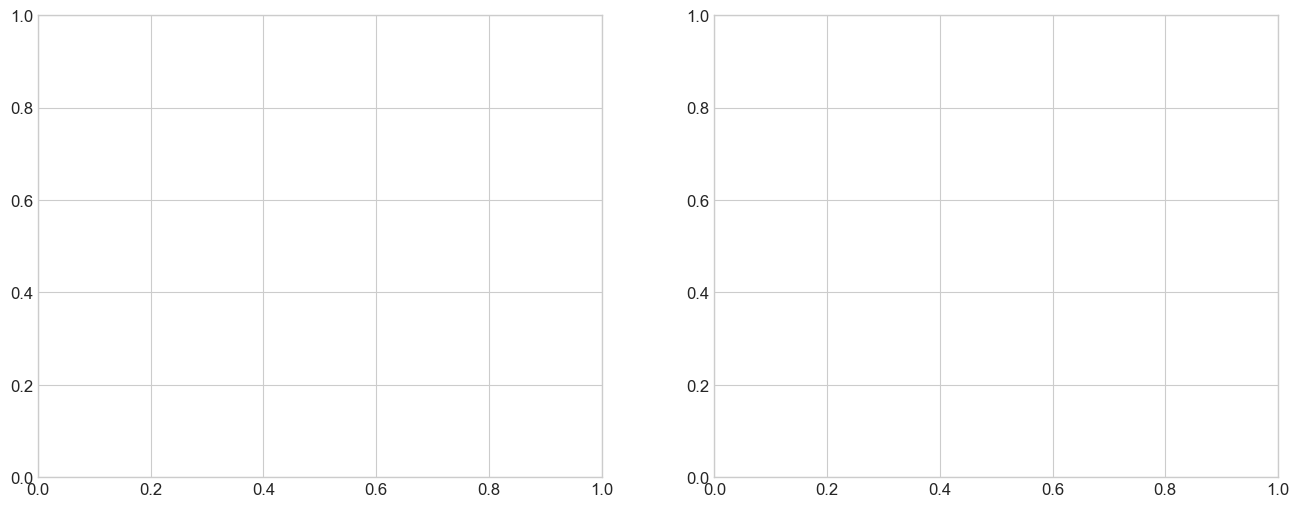

In [2]:
# =============================================================================
# 2. ROBUST TRAINING METHODS
# =============================================================================
# This section implements Dropout regularization as a simple and effective
# robust training technique to make models more resistant to poisoning attacks.
# Method: Dropout regularization (simplest to implement)


from scripts.train import *
from scripts.visualize import *


print("=== ROBUST TRAINING METHODS ===")

# Ensure we have cleaned data from previous step
if 'X_train_cleaned' not in globals():
    print("⚠ Using original poisoned data - data sanitization step not completed")
    X_train_robust = X_train_poisoned
    y_train_robust = y_train_poisoned
else:
    print("✓ Using cleaned data from data sanitization step")
    X_train_robust = X_train_cleaned
    y_train_robust = y_train_cleaned

print(f"Training data shape: {X_train_robust.shape}")
print(f"Number of training samples: {len(X_train_robust)}")

# Prepare data for training
num_classes = len(np.unique(y_train))
y_train_robust_cat = to_categorical(y_train_robust, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# =============================================================================
# 2.1 BASELINE MODEL (WITHOUT DROPOUT)
# =============================================================================
print("\n2.1 Building Baseline Model (No Dropout)")

# Build and train baseline model
baseline_model = build_model(X_train_robust.shape[1], num_classes)
print("✓ Baseline model architecture:")
baseline_model.summary()

print("\n🚀 Training baseline model...")
baseline_history = train_model(baseline_model, X_train_robust, y_train_robust_cat, X_val, y_val_cat)

# Evaluate baseline model
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"✓ Baseline model test accuracy: {baseline_test_acc:.4f}")

# =============================================================================
# 2.2 ROBUST MODEL WITH DROPOUT REGULARIZATION
# =============================================================================
print("\n2.2 Building Robust Model with Dropout Regularization")

# Build robust model with different dropout rates
dropout_rates = [0.2, 0.3, 0.5]
dropout_models = {}
dropout_histories = {}
dropout_test_accs = {}

for dropout_rate in dropout_rates:
    print(f"\n  Training model with dropout rate = {dropout_rate}")
    
    # Build model
    model = build_dropout_model(X_train_robust.shape[1], num_classes, dropout_rate)
    
    # Train model
    history = model.fit(
        X_train_robust, y_train_robust_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0
    )
    
    # Evaluate model
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
    
    # Store results
    dropout_models[dropout_rate] = model
    dropout_histories[dropout_rate] = history
    dropout_test_accs[dropout_rate] = test_acc
    
    print(f"  ✓ Dropout {dropout_rate} model test accuracy: {test_acc:.4f}")

# Select best dropout model
best_dropout_rate = max(dropout_test_accs, key=dropout_test_accs.get)
best_dropout_model = dropout_models[best_dropout_rate]
best_dropout_history = dropout_histories[best_dropout_rate]

print(f"\n✓ Best dropout rate: {best_dropout_rate} (accuracy: {dropout_test_accs[best_dropout_rate]:.4f})")

# =============================================================================
# 2.3 COMPARISON AND VISUALIZATION
# =============================================================================
print("\n2.3 Model Comparison and Visualization")

# Performance comparison
print(f"Baseline model accuracy: {baseline_test_acc:.4f}")
print(f"Best dropout model accuracy: {dropout_test_accs[best_dropout_rate]:.4f}")
print(f"Improvement: {((dropout_test_accs[best_dropout_rate] - baseline_test_acc) * 100):+.2f}%")


compare_model_training_history(baseline_history, best_dropout_history)


# =============================================================================
# 2.4 RESULTS SUMMARY
# =============================================================================
print("\n=== ROBUST TRAINING RESULTS ===")
print(f"✓ Implemented Dropout regularization ")
print(f"✓ Best dropout rate: {best_dropout_rate}")
print(f"✓ Baseline accuracy: {baseline_test_acc:.4f}")
print(f"✓ Dropout accuracy: {dropout_test_accs[best_dropout_rate]:.4f}")
print(f"✓ Performance change: {((dropout_test_accs[best_dropout_rate] - baseline_test_acc) * 100):+.2f}%")
print(f"✓ Overfitting reduction: {((baseline_gap[-1] - dropout_gap[-1]) * 100):+.2f}%")

# Store results for later phases
globals()['baseline_model'] = baseline_model
globals()['robust_model'] = best_dropout_model
globals()['robust_training_metrics'] = {
    'baseline_accuracy': baseline_test_acc,
    'dropout_accuracy': dropout_test_accs[best_dropout_rate],
    'best_dropout_rate': best_dropout_rate,
    'performance_improvement': (dropout_test_accs[best_dropout_rate] - baseline_test_acc) * 100,
    'overfitting_reduction': (baseline_gap[-1] - dropout_gap[-1]) * 100
}

print("✓ Robust training with Dropout completed")

## Phase 2: Adversarial Defense Strategies

### 3. Input Preprocessing Defenses
- Test randomized smoothing techniques

In [ ]:
# =============================================================================
# 3. INPUT PREPROCESSING DEFENSES
# =============================================================================
# This section will implement input preprocessing techniques to defend against
# adversarial examples at inference time.
# Methods: Randomized smoothing, Input transformations, Noise injection

### 4. Model Hardening
- Apply adversarial training with PGD examples
- Explore certified robustness methods (IBP/RS-Certify)

In [ ]:
# =============================================================================
# 4. MODEL HARDENING
# =============================================================================
# This section will implement model hardening techniques to make neural networks
# more robust against adversarial attacks.
# Methods: Adversarial training with PGD, Certified robustness (IBP/RS-Certify)

## Phase 3: Defense Evaluation

### 5. Quantitative Analysis
- Compare metrics before/after defenses:
  - Clean data accuracy preservation
  - Attack success rate reduction
  - Computational overhead

In [ ]:
# =============================================================================
# 5. QUANTITATIVE ANALYSIS
# =============================================================================
# This section will provide quantitative evaluation of defense effectiveness
# by comparing key metrics before and after applying defenses.
# Metrics: Clean accuracy preservation, Attack success rate reduction, Computational overhead

### 6. Qualitative Analysis
- Visualize decision boundary changes
- Conduct gradient sensitivity analysis

In [ ]:
# =============================================================================
# 6. QUALITATIVE ANALYSIS
# =============================================================================
# This section will provide visual and qualitative analysis of how defenses
# change model behavior and decision boundaries.
# Analysis: Decision boundary visualization, Gradient sensitivity analysis